In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Define File Paths & Load to DataFrame

In [2]:
BASE_PATH = './2025_A2/train'
METADATA_PATH = BASE_PATH + '/train_metadata.csv'
metadata = pd.read_csv(METADATA_PATH)   # columns: image_id, ClassId
# test_meta  = pd.read_csv("test_metadata.csv")    # columns: image_id

FEATURE_PATH = BASE_PATH + '/Features'

print(FEATURE_PATH + "/additional_features.csv")

./2025_A2/train/Features/additional_features.csv


# Data Processing

### Join evety feature CSV with ClassID in metadata

In [4]:
# load data
add_feats  = pd.read_csv(FEATURE_PATH + "/additional_features.csv")  
color_hist = pd.read_csv(FEATURE_PATH + "/color_histogram.csv")     
hog_pca    = pd.read_csv(FEATURE_PATH + "/hog_pca.csv")         

hog_pca = hog_pca.merge(
    metadata[["image_path", "ClassId"]],
    on="image_path",
    how="left"
)

add_feats = add_feats.merge(
    metadata[["image_path", "ClassId"]],
    on="image_path",
    how="left"
)

color_hist = color_hist.merge(
    metadata[["image_path", "ClassId"]],
    on="image_path",
    how="left"
)

print(hog_pca.columns, end="\n\n")
print(add_feats.columns, end="\n\n")
print(color_hist.columns, end="\n\n")

Index(['image_path', 'hog_pca_0', 'hog_pca_1', 'hog_pca_2', 'hog_pca_3',
       'hog_pca_4', 'hog_pca_5', 'hog_pca_6', 'hog_pca_7', 'hog_pca_8',
       'hog_pca_9', 'hog_pca_10', 'hog_pca_11', 'hog_pca_12', 'hog_pca_13',
       'hog_pca_14', 'hog_pca_15', 'hog_pca_16', 'hog_pca_17', 'hog_pca_18',
       'hog_pca_19', 'ClassId'],
      dtype='object')

Index(['image_path', 'edge_density', 'mean_b', 'mean_g', 'mean_r', 'ClassId'], dtype='object')

Index(['image_path', 'ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6',
       'ch_7', 'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14',
       'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22',
       'ch_23', 'ch_24', 'ch_25', 'ch_26', 'ch_27', 'ch_28', 'ch_29', 'ch_30',
       'ch_31', 'ch_32', 'ch_33', 'ch_34', 'ch_35', 'ch_36', 'ch_37', 'ch_38',
       'ch_39', 'ch_40', 'ch_41', 'ch_42', 'ch_43', 'ch_44', 'ch_45', 'ch_46',
       'ch_47', 'ch_48', 'ch_49', 'ch_50', 'ch_51', 'ch_52', 'ch_53', 'ch_54',
  

# Data Visualization

### ClassID Distribution

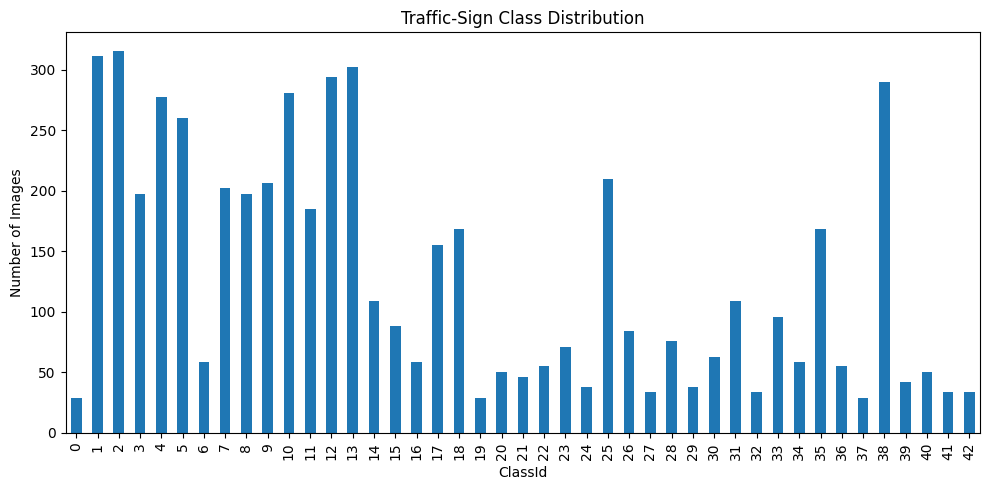

In [7]:
class_counts = metadata["ClassId"].value_counts().sort_index()

# 3. bar-plot the distribution
plt.figure(figsize=(10, 5))
class_counts.plot(kind="bar")               # one bar per ClassId
plt.xlabel("ClassId")
plt.ylabel("Number of Images")
plt.title("Traffic-Sign Class Distribution")
plt.tight_layout()
plt.show()